In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io import fits

In [3]:
from astropy.io import fits
import sys
sys.path.append("/home/msdos/um_scripts/")
sys.path.append("/home/faoli/programs/desi/desiarc/arc/")
# import find_center as fc
from spotfinder import spotfinder

import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import time
import pandas as pd
from scipy.stats import norm
import matplotlib.colors as mcolors

In [4]:
files= !ls /home/msdos/um_scripts/sbigpics/fiducials/*.fits
fiducial_pic = '20230210-140946.fits' #files[0]
files[0]

'/home/msdos/um_scripts/sbigpics/fiducials/20221212-172028.fits'

In [5]:
def find_spot(fitsname, fitspath,  
              expected_spot_count=1, 
              regionsname='../regions.reg', 
              verbose=False):
    """
    spotfinder handler
    input:
        fitsname:
        fitspath (str): relative or full path to the folder
        regionsname (str):
        verbose (bool):
    output: 
        centroids (dict): raw output from spotfinder

    """
    assert isinstance(fitsname, str)

    _ifn = f"{fitspath}/{fitsname}"

#     if expected_spot_count != 1:
#         raise NotImplementedError("This mode wasn't tested here")
    try: 
        sf=spotfinder.SpotFinder(_ifn, expected_spot_count)
        centroids = sf.get_centroids(print_summary = verbose, 
                                     region_file=regionsname)
        if verbose: print(centroids)
    
    except: #ignore photo if an error is raised
        print("Warning: spot not found ")
        inval_number = np.nan
        return {  'peaks': [inval_number], 
                      'x': [inval_number], 
                      'y': [inval_number], 
                   'fwhm': [inval_number], 
                 'energy': [inval_number]} 
    return centroids


def collect_xy(files, picspath):
    # treating for single file
    if isinstance(files, str):
        files = [files]
    x2, y2 = [],[]
    for fullname in files:
        iname = fullname.split('/')[-1]
        _c = find_spot(iname, picspath)
        x2.append(_c['x'])
        y2.append(_c['y'])
    return x2, y2

## Get fiducials spots:

In [6]:
dd = find_spot(fiducial_pic, 
               '/home/msdos/um_scripts/sbigpics/fiducials/', 
               regionsname=False, 
               expected_spot_count=4)

Edge hot spot
Edge hot spot
peak = 83511.40868290901 brightness appears out of expected range
peak = 82574.85482244717 brightness appears out of expected range
peak = 73914.44959975324 brightness appears out of expected range
peak = 68526.54260075433 brightness appears out of expected range


### Visual inspection

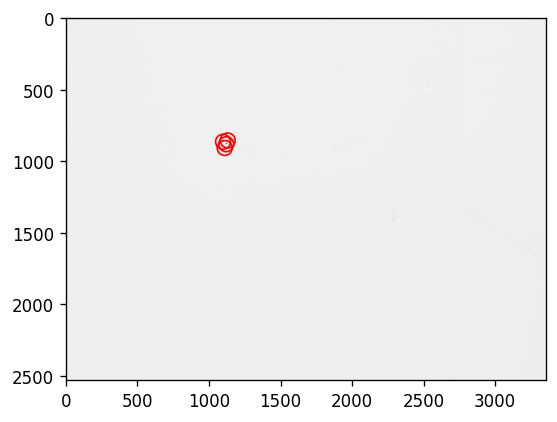

In [14]:
img = fits.getdata(f"/home/msdos/um_scripts/sbigpics/fiducials/{fiducial_pic}")
plt.figure(dpi=120)
plt.imshow(np.log(img), cmap='gray_r', origin='lower')
plt.scatter(dd['x'], dd['y'],  s=80, facecolors='none', edgecolors='r')
plt.gca().invert_yaxis()


(900.0, 1300.0)

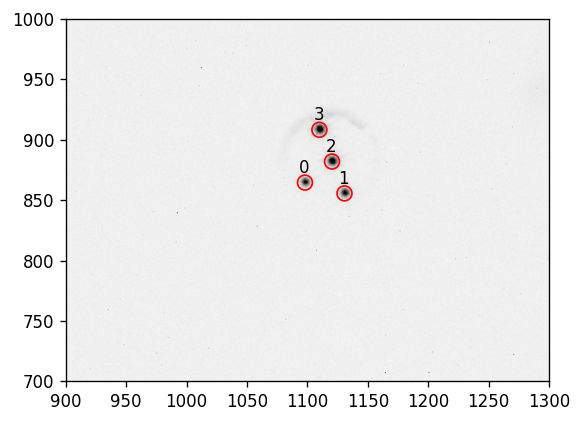

In [15]:
img = fits.getdata(f"/home/msdos/um_scripts/sbigpics/fiducials/{fiducial_pic}")
plt.figure(dpi=120)
plt.gca().invert_yaxis()
plt.imshow(np.log(img), cmap='gray_r', origin='lower')
plt.scatter(dd['x'], dd['y'],  s=80, facecolors='none', edgecolors='r')
for pt, (i,j) in enumerate(zip(dd['x'], dd['y'])):
    plt.annotate(pt, xy=(i-5,j+8), xycoords='data')
plt.ylim([700, 1000])
plt.xlim(900, 1300)

### Get calibration

In [16]:
cx = np.array(dd['x'])
cy = np.array(dd['y'])
d = lambda i, j: np.hypot(cx[j] -cx[i], cy[j] - cy[i])

# User should MATCH ORDER OF SPOTS
dphys = { (3,2):1,(3,1):2, (3,0):1.6, (2,1):1, (2,0):1,  (1,0):1.2  }
ratioall = np.array([])
dph =  np.array([1, 2, 1.6, 1, 1, 1.2]) # weighting by the distance
pix2mm = np.array([])
for i,j in [(3,2), (3,1), (3,0), (2,1), (2,0), (1,0)]:
    _x = d(i,j)/dphys[(i,j)]
    ratioall = np.append(ratioall, _x)
    pix2mm = np.append(pix2mm, dphys[(i,j)]/d(i,j))
# assert pix2mm
    
print(f"{ratioall.mean():.4f} +/- {np.std(ratioall, ddof=1):.4f}")
mu_mm2pix = (ratioall*dph).sum() /dph.sum()
std_mm2pix = np.sqrt( np.sum(dph* (ratioall-mu_mm2pix)**2)/ ( dph.sum() * (len(dph)-1)/len(dph) ) )

def stats(pix2mm, w):
    # w: dph Physical distance in the model
    N = len(w!=0)
    _mu = np.sum(pix2mm * w)/w.sum()
    _std = np.sum(w * (pix2mm - _mu)**2)/( w.sum() * ((N-1)/N) )
    _std = np.sqrt(_std)
    return _mu, _std

# ------------
# Calibration 
# weighting values based on the (expected) distance size from template
mu1, std1 = stats(pix2mm, dph)
mu2, std2 = stats(pix2mm, np.ones_like(pix2mm))
    
print(f"weighted: {mu_mm2pix:.4f} +/- {std_mm2pix:.4f}" )
print(f"weighted: {mu1:.6f} +/- {std1:.6f}" )
ratioall, (ratioall*dph).sum() /dph.sum(),  #mu2, std2, 1/mu2

28.3002 +/- 0.0298
weighted: 28.2989 +/- 0.0271
weighted: 0.035337 +/- 0.000034


(array([28.28186647, 28.29767413, 28.30180979, 28.31365783, 28.34728354,
        28.25893036]),
 28.29894464125357)